In [1]:
hp1={'alpha': 0.28815202419377745,
 'ccp_alpha': 5.934643617038572,
 'criterion': 0,
 'learning_rate': 0.18713205647733647,
 'loss': 0,
 'max_depth': 6.0,
 'min_impurity_decrease': 12.184228522266157,
 'min_samples_split': 0.2792395135807041,
 'min_weight_fraction_leaf': 0.030673769520341967,
 'n_estimators': 6618.0,
 'subsample': 0.4245813194818062}

In [387]:
hp2={'alpha': 0.16234148344961263,
 'ccp_alpha': 8.419901955112628,
 'criterion': 1,
 'learning_rate': 0.0941839372553873,
 'loss': 0,
 'max_depth': 6.0,
 'min_impurity_decrease': 12.150004214829083,
 'min_samples_split': 0.18518840581261817,
 'min_weight_fraction_leaf': 0.022548950312775547,
 'n_estimators': 4403.0,
 'subsample': 0.4208126529136677}

feat2=['MSSubClass' 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd'
 'MoSold' 'LotFrontage' 'LotArea' 'MasVnrArea' 'BsmtFinSF1' 'BsmtUnfSF'
 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'BsmtFullBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces'
 'GarageYrBlt' 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF'
 'ScreenPorch' 'MSZoning' 'LandContour' 'LotConfig' 'Neighborhood'
 'Condition1' 'BldgType' 'HouseStyle' 'Exterior1st' 'Exterior2nd'
 'ExterQual' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'HeatingQC' 'CentralAir' 'KitchenQual' 'Functional' 'GarageType'
 'GarageFinish' 'SaleCondition']

# **House Prices Regression Predicction Model**
## **Introduction**
### Dataset Overview
The data model study below is based on Kaggle open dataset: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

This is US Housing dataset in Ames, Lowa. It cotains 79 features related to house information such as SalePrice, LotArea, YearBuilt and quality Condition.

### Objective
The goal is to predict the housing price using historical data and explain what are the key factors afffecting the house price.

### Model Training Flow
1. Data Cleaning & Exploration
2. Data Transformation
3. Model Selection
4. Base Model Training
5. Feature Engineering and Model Finetune
6. Conclusion

## **Import Libaries**
Common libraries for data plotting and model training.
Optuna library is used for model hyperparameter optimization.

In [542]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
rs= RobustScaler()
from sklearn.preprocessing import OrdinalEncoder
oe=OrdinalEncoder()
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()

from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.linear_model import Ridge as RG
from sklearn import linear_model
Lasso = linear_model.Lasso(alpha=0.1)
Lars = linear_model.Lars(n_nonzero_coefs=1)
LassoLars=linear_model.LassoLars(alpha=0.01)
from xgboost import XGBRegressor as XGBR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR

import optuna

#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_validate
#from sklearn import metrics
#from sklearn.model_selection import ShuffleSplit
#from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import f1_score
#from sklearn.metrics import precision_score
#from RegscorePy import *
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

import shap

#from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [ ]:
#import previous project funtions from kit.py
from kit import *

## **1. Data Cleaning & Exploration**
### **Section Summary:**

### **Section Highlights:**


In [2]:
df=pd.read_csv("train.csv")

Quick check has found 'NaN' in train data

In [3]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


High level understanding on data. The target response is 'SalePrice'. It has positive skew and high outlier price.

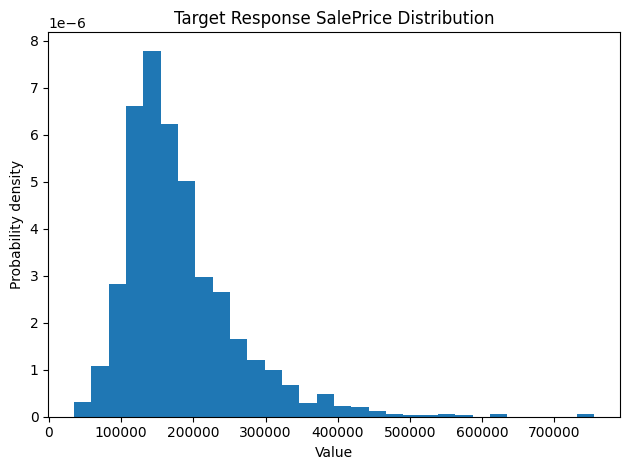

In [4]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(df['SalePrice'], 30, density=True)
ax.set_xlabel('Value')
ax.set_ylabel('Probability density')
ax.set_title('Target Response SalePrice Distribution')
fig.tight_layout()
plt.show()

No duplication.

In [5]:
df.duplicated().sum()

0

At least has two unique values.

In [6]:
df.nunique().sort_values(ascending=False)

Id            1460
LotArea       1073
GrLivArea      861
BsmtUnfSF      780
1stFlrSF       753
              ... 
HalfBath         3
Street           2
CentralAir       2
Utilities        2
Alley            2
Length: 81, dtype: int64

There are many features having high missing values.

In [7]:
df.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

Create function to investigate the missing values.

In [8]:
def missing_feat(df):
    null_col=pd.DataFrame(columns=['Feature','Total Transaction','Transaction with Missing Value','Missing %'])
    null_col_index=0
    for i in df.isnull().sum().sort_values(ascending=False).index:
        null_col.loc[null_col_index]=[i,
                                    len(df),
                                    df[i].isnull().sum(),
                                    float(df[i].isnull().sum()/len(df))*100,
                                    ]
        null_col_index=null_col_index+1

    print('Features with missing values')
    display(null_col[null_col['Missing %']>0])

    fig = px.ecdf(null_col, x="Missing %",marginal="histogram",title="Cumulative Distribution of Feature(column) Missing Percentage")

    fig.update_layout(xaxis_title='Missing %',
                        yaxis_title='Accumulated Feature Density',
                        )  

    fig.show()

    return null_col

About 25% features contain missing feature, from ~5% to ~95% missing.

In [9]:
feat_missing_df=missing_feat(df)

Features with missing values


,Feature,Total Transaction,Transaction with Missing Value,Missing %
0,PoolQC,1460,1453,99.520548
1,MiscFeature,1460,1406,96.301370
2,Alley,1460,1369,93.767123
3,Fence,1460,1179,80.753425
4,MasVnrType,1460,872,59.726027
5,FireplaceQu,1460,690,47.260274
6,LotFrontage,1460,259,17.739726
7,GarageYrBlt,1460,81,5.547945
8,GarageCond,1460,81,5.547945
9,GarageType,1460,81,5.547945


There are features with almost 90% missing values! However the data description file provided by dataset explain certain housing feature are not available, hence it is NaN in the dataset. For example, 'PoolQC' is the quality assessment for the pool:

In [10]:
df['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

There is also feature related to pool area 'PoolArea'. For 'PoolArea' more than 0 (i.e. the house has pool), there are no missing 'PoolQC', in another words, the 'PoolQC' is available only for house with pool. 'Ex' is Excellent, 'Fa' is Fair, etc...

In [12]:
df[['PoolArea','PoolQC']][df['PoolArea']>0]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd


Similarly for 'MiscFeature', it is miscellaneous feature which is not covered in other categories. It should be kept as well. 'MiscVa' is the value of the 'MiscFeature'.

In [13]:
df['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [14]:
df[['MiscVal','MiscFeature']][df['MiscVal']>0]

,MiscVal,MiscFeature
5,700,Shed
7,350,Shed
16,700,Shed
17,500,Shed
51,400,Shed
84,700,Shed
95,480,Shed
98,400,Shed
99,400,Shed
106,450,Shed


Similarly,
1. 'Alley': Type of alley access
2. 'Fence': Fence quality
3. 'MasVnrType': Masonry veneer type; 'MasVnrArea': Masonry veneer area in square feet
4. 'FireplaceQu': Fireplace quality; 'Fireplaces': Number of fireplaces
5. 'LotFrontage': Linear feet of street connected to property
6. 'GarageYrBlt': Year garage was built; 'GarageType': Garage location; 'GarageCond': Garage condition

In conclusion, these are valid data and do not have to remove them. Data transformation will be applied on the NaN values before model training.

In [15]:
#Not used
def missing_row(df):
    null_row=pd.DataFrame(columns=['Row ID','Total Feature','Feature With Missing Value','Missing %'])
    null_row_index=0
    for i in range(len(df)):
        if df.iloc[i].isnull().sum()>0:
            null_row.loc[null_row_index]=[df['Id'][i],
                                        len(df.columns),
                                        df.iloc[i].isnull().sum(),
                                        float(df.iloc[i].isnull().sum()/len(df.columns))*100,
            ]
            null_row_index=null_row_index+1

    print('Transaction with missing feature value')
    display(null_row.sort_values(ascending=False,by='Missing %'))

    fig = px.ecdf(null_row, x="Missing %",marginal="histogram",title="Cumulative Distribution of Transaction (row ID) Missing Percentage")

    fig.update_layout(xaxis_title='Missing %',
                        yaxis_title='Accumulated Row Density',
                        )
            
    fig.show()

    return null_row

Moving to data exploration. First thing to find which are numeric and categorical features:

Drop 'Id' and 'SalePrice' befire feature transformation

In [16]:
feat_df=df.drop(['Id','SalePrice'],axis=1)

In [17]:
cat_feat = feat_df.select_dtypes(include=['object', 'bool']).columns
cat_feat.sort_values()

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street', 'Utilities'],
      dtype='object')

In [18]:
num_feat = feat_df.select_dtypes(include=['int64', 'float64']).columns
num_feat.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea',
       'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'],
      dtype='object')

'MSSubClass' is int type but it is supposed to be categorical, hence it is grouped under cat_feat
MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

In [19]:
num_feat=num_feat.drop('MSSubClass')
num_feat

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [20]:
cat_feat=cat_feat.insert(len(cat_feat),'MSSubClass')
cat_feat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition', 'MSSubClass'],
      dtype='object')

Create conversion function to convert the quality with ordinary label.
1. Ex	Excellent     ->5
2. Gd	Good   ->4
3.TA	Typical - slight dampness allowed  ->3
4. Fa	Fair - dampness or some cracking or settling     ->2
5. Po	Poor - Severe cracking, settling, or wetness     ->1
6. NA	No Basement   ->0

For numerical feature, quick check on the correlation with the target response 'SalePrice':

In [21]:
#interactive corrrelation heatmap for numberic feat.Roughly check the correlation with target SalePrice, and their intercorrelation
def corr_map(df,included_col,target_response):
    corr_df=df
    for i in corr_df.columns:
        if i not in included_col:
            corr_df=corr_df.drop([i],axis=1)
    
    corr_df=pd.concat([corr_df,df[target_response]],axis=1)

    print('Correlation score with SalePrice:')
    display(corr_df.corr()['SalePrice'].sort_values(ascending=False))
    fig = px.imshow(corr_df.corr(),
                    width=1200,
                    height=800,
                    #text_auto=True,
                    title='Correlation Map'
                    )
    fig.show()
    return corr_df.corr()

### Data visualization
'OverallQual', 'GrLivingArea' are the top 2 numerical features with more than +0.7 corretion score

In [22]:
num_feat_corr=corr_map(df,num_feat,'SalePrice')

Correlation score with SalePrice:


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

'OverallCond' is rating of overall material and finishing condition (1 to 10), while 'GrLivArea' is 'above grade (ground) living area square feet'. In scatter plot below, Y axis is the 'SalePrice', X axis is the 'GrLivArea' and the color intensity follow the 'OverallCond'. It is clear that with larger above grade living area and better overall condition, the sale price is higher.

In [23]:
fig = px.scatter(df, x='GrLivArea',y='SalePrice',color='OverallCond')
fig.show()

The t-test function select a pair of subgroups from categorical feature to perform ANOVA test baseed on the target response 'SalePrice'. For categorical features, t-test will be used to see if any abnormal distinction is found.

In [24]:
#convert feat subgroup into series for t-test
def series_dict(df1):
    a={}
    for i in df1.index:
        if df1.iloc[i][0] not in a:
            a.update({df1.iloc[i][0]:[df1.iloc[i][1]]})
        if df1.iloc[i][0] in a:
            a[df1.iloc[i][0]].append(df1.iloc[i][1])
    return a

#t-test for the feature value from series
def series_ttest2(a):
    i_keys=list(a.keys())
    t_result=pd.DataFrame(columns=['feat_var1','feat_var2','p value','statistic','df'])
    index=0
    for i in range(len(i_keys)):
        if i+1<len(i_keys):
            for k in range(i+1,len(i_keys)):
                t=stats.ttest_ind(a[i_keys[i]],a[i_keys[k]])
                t_result.loc[index]=[str(i_keys[i]),str(i_keys[k]),t.pvalue,t.statistic,t.df]
                index=index+1
    return t_result

In [25]:
#t-test feature feat from dataframe
def feat_ttest(df,feat,target_response):
    sig_result=pd.DataFrame(columns=['feat','min one pair feat_val reject h0','feat_val1','feat_val2','p value','statistic','degree of fredom'])
    sig_result_index=0
    for i in feat:
        df1=df[[i,target_response]]
        a=series_dict(df1)
        t_result=series_ttest2(a)
        t_result_min_p_index=t_result.idxmin()[2]
        #print(i,t_result.iloc[t_reult_min_p_index][2])
        if t_result.iloc[t_result_min_p_index][2]<0.05:
            h0_result=True
        if t_result.iloc[t_result_min_p_index][2]>0.05:
            h0_result=False
        sig_result.loc[sig_result_index]=[i,
                                          h0_result,
                                          t_result.iloc[t_result_min_p_index][0],
                                          t_result.iloc[t_result_min_p_index][1],
                                          t_result.iloc[t_result_min_p_index][2],
                                          t_result.iloc[t_result_min_p_index][3],
                                          t_result.iloc[t_result_min_p_index][4],
                                          ]
        sig_result_index=sig_result_index+1
        
    return sig_result.sort_values(by=['p value'])

The series_ttest2 function is used to check individual categorical feature t-test result.
For example for 'ExterQual', all feat var comparisons are showing very low p values.
The top 5 features only have 2 degrees of fredom, the sample sizes are too small, should not be considered true distinction;
'ExterQual','KitchenQual' and other quality related features have shown the there are distinction between 'TA' (typical or average) and 'Ex' (Excellent). Example is shown below, where 'Ex' has much higher SalePrice than 'TA':

In [26]:
cat_feat_result=feat_ttest(df,cat_feat,'SalePrice')
cat_feat_result.style.format({'p value': '{:.2g}','statistic':'{:.2f}','df':'{:.0f}'})

,feat,min one pair feat_val reject h0,feat_val1,feat_val2,p value,statistic,degree of fredom
15,Exterior1st,True,AsphShn,ImStucc,0,-inf,2.000000
14,RoofMatl,True,Metal,Membran,0,-inf,2.000000
29,Electrical,True,Mix,nan,0,-inf,2.000000
16,Exterior2nd,True,Other,CBlock,0,inf,2.000000
10,Condition2,True,PosA,RRAn,0,inf,2.000000
18,ExterQual,True,TA,Ex,3.5e-153,-31.97,958.000000
30,KitchenQual,True,TA,Ex,4.7e-148,-32.12,835.000000
21,BsmtQual,True,TA,Ex,3.6e-140,-31.43,770.000000
34,GarageFinish,True,Unf,Fin,1.5e-81,-21.12,957.000000
32,FireplaceQu,True,nan,Gd,1.4e-78,-20.43,1070.000000


In [27]:
a=series_ttest2(series_dict(df[['ExterQual','SalePrice']]))
a.sort_values(by=['p value']).style.format({'p value': '{:.2g}','statistic':'{:.2f}','df':'{:.0f}'})

,feat_var1,feat_var2,p value,statistic,df
3,TA,Ex,3.5e-153,-31.97,958
0,Gd,TA,2.4e-142,28.65,1394
1,Gd,Ex,1.5e-30,-12.24,540
2,Gd,Fa,7.3e-14,7.70,502
5,Ex,Fa,2.5e-13,9.13,66
4,TA,Fa,7.8e-07,4.97,920


viz_response_by_feat_category will plot all the category feature in violin plot. Example for 'ExterCond' (Exterior material quality) is shown below:

![alt text](Assets/ExterQual.png)

viz_response_by_feat_category function will plot the features found reject the h0 hypothesis.

In [28]:
def viz_response_by_feat_category(df,ttest_result,target_response):
    for i in ttest_result['feat']:
        plt.figure(figsize=(10,5))
        sns.violinplot(df,x=i, y=target_response)
        plt.title(f"{i} vs {target_response}")
        plt.xticks(rotation=90)

In [ ]:
viz_response_by_feat_category(df,cat_feat_result,'SalePrice')

Deeper look on individual feature
Inspect feature value normality by normal test and viz

In [29]:
def viz_series_dist(df,feat,target_response):
    df1=df[[feat,target_response]]
    a=series_dict(df1)
    for i in a.keys():
        nor=stats.normaltest(a[i])
        print('feature:',feat,'feat_val:',i,': p value:%.2g statistic:%.2f'%(nor.pvalue,nor.statistic))
        
        fig, ax = plt.subplots()
        n, bins, patches = ax.hist(a[i], 30, density=True)
        ax.set_xlabel('Value')
        ax.set_ylabel('Probability density')
        ax.set_title(f'{feat}_Feature_Value: {i} Distribution')
        fig.tight_layout()
        plt.show()
    

Most of the 'ExterQual' values are normally distributed

feature: ExterQual feat_val: Gd : p value:7.9e-48 statistic:216.92


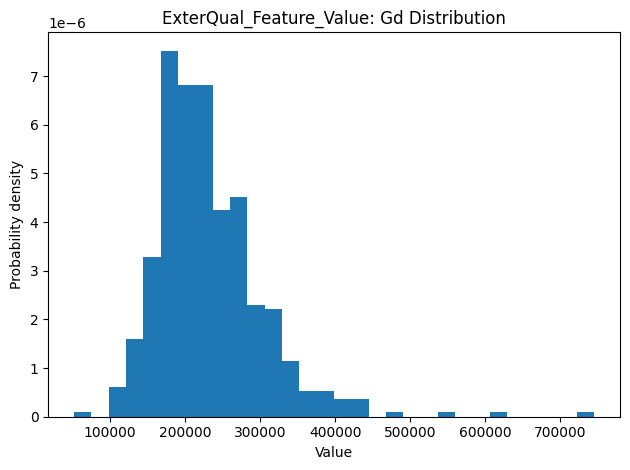

feature: ExterQual feat_val: TA : p value:2.8e-47 statistic:214.35


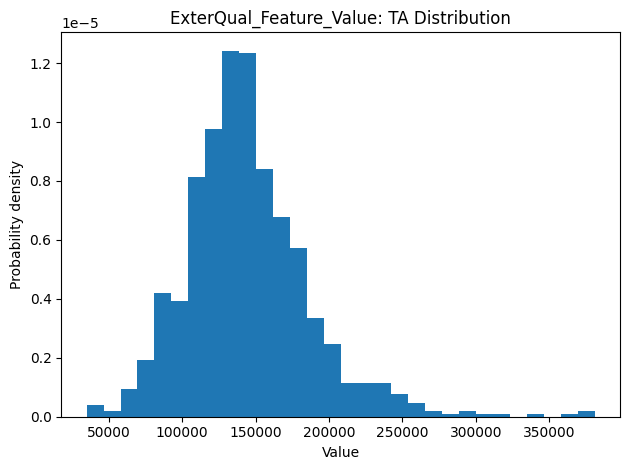

feature: ExterQual feat_val: Ex : p value:0.011 statistic:8.97


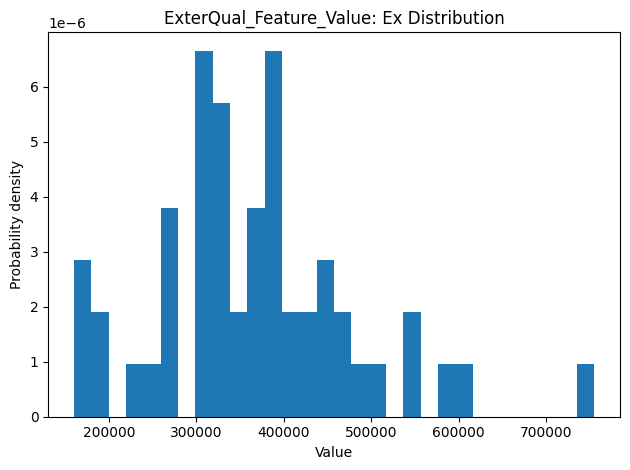

feature: ExterQual feat_val: Fa : p value:0.0018 statistic:12.69


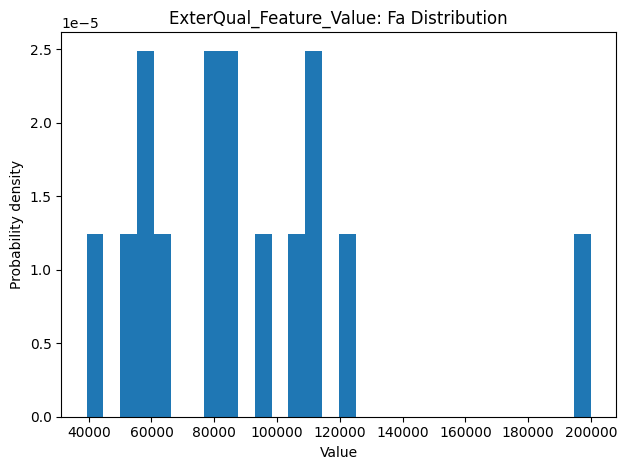

In [30]:
viz_series_dist(df,'ExterQual','SalePrice')

## **2. Data Transformation & Spliting**
### **Summary:**

### **Section Highlights:**


Based on data description, convert various categorical data into rating (int) data, and for featur values without the specic feature, fill null with zero (eg: for no garage, GarageBuilt Yr=0)

In [985]:
def df_conversion(df):
    tr=df.copy()    
    conversion1_feat=['ExterQual',
                 'ExterCond',
                 'BsmtQual',
                 'BsmtCond',
                 'HeatingQC',
                 'KitchenQual',
                 'FireplaceQu',
                 'GarageQual',
                 'GarageCond',
                 'PoolQC',
                 ]
    tr1=tr[conversion1_feat]
    for i in tr1.columns:
        tr1=tr1.replace(
            {
                np.nan:0,
                'Po':1,
                'Fa':2,
                'TA':3,
                'Gd':4,
                'Ex':5
            }
        )

    conversion2_feat=['BsmtExposure',
                  ]
    tr2=tr[conversion2_feat]
    for i in tr2.columns:
        tr2=tr2.replace(
            {
                np.nan:0,
                'No':1,
                'Mn':2,
                'Av':3,
                'Gd':4,
            }
        )

    conversion3_feat=['BsmtFinType1',
                  'BsmtFinType2',
                  ]
    tr3=tr[conversion3_feat]
    for i in tr3.columns:
        tr3=tr3.replace(
            {
                np.nan:0,
                'Unf':1,
                'LwQ':2,
                'Rec':3,
                'BLQ':4,
                'ALQ':5,
                'GLQ':6
            }
        )

    conversion4_feat=['Fence']
    tr4=tr[conversion4_feat]
    for i in tr4.columns:
        tr4=tr4.replace(
            {
                np.nan:0,
                'MnWw':1,
                'GdWo':2,
                'MnPrv':3,
                'GdPrv':4,
            }
        )

    conversion5_feat=['LotFrontage',
                      'GarageYrBlt',
                      'MasVnrArea',
                      'estimated_garage_age(yr)',
                      'estimated_garage_age((month)',
                      #'Electrical'
                      ]
    tr5=tr[conversion5_feat]
    for i in tr5.columns:
        tr5=tr5.replace(
            {
                np.nan:0,
            }
        )

    return pd.concat([tr1,tr2,tr3,tr4,tr5],axis=1)


In [306]:
a=df.copy()

In [971]:
a['estimated house age(month)']=(a['YrSold']*12+a['MoSold'])-(a['YearBuilt']*12)

In [972]:
fig = px.scatter(a, x='estimated house age(month)',y='SalePrice',color='OverallCond')
fig.show()

In [ ]:
a['YrMoSold']=(a['YrSold']*100+a['MoSold'])

In [979]:
fig = px.scatter(a, x='YrMoSold',y='SalePrice',color='OverallCond')
fig.show()

In [1045]:
def data_transform(df):
    tr=df.copy()
    tr['estimated_house_age(month)']=(tr['YrSold']*12+tr['MoSold'])-(tr['YearBuilt']*12)
    tr['estimated_house_age(yr)']=(tr['YrSold'])-(tr['YearBuilt'])
    tr['YrMoSold']=(tr['YrSold']*100+tr['MoSold'])
    tr['estimated_remodadd_age(yr)']=(tr['YrSold'])-(tr['YearRemodAdd'])
    tr['estimated_remodadd_age(month)']=(tr['YrSold']*12+tr['MoSold'])-(tr['YearRemodAdd']*12)
    tr['estimated_garage_age(yr)']=(tr['YrSold'])-(tr['GarageYrBlt'])
    tr['estimated_garage_age((month)']=(tr['YrSold']*12+tr['MoSold'])-(tr['GarageYrBlt']*12)
    print(f'New features are created, the df contains {len(tr.columns)} columns;')

    feat_df=tr.drop(['SalePrice','Id'],axis=1)
    print(f'After droping SalePrice and Id columns, it has total {len(feat_df.columns)} features;')
    
    converted_df=df_conversion(tr)
    print(f'Based on the data description, {len(converted_df.columns)} features are converted from categorical into ordinal features, mostly are rating related;')

    feat_df=feat_df.drop(converted_df.columns,axis=1)
    cat_feat = feat_df.select_dtypes(include=['object', 'bool']).columns
    num_feat = feat_df.select_dtypes(include=['int64', 'float64']).columns
    num_feat=num_feat.drop('MSSubClass')
    cat_feat=cat_feat.insert(len(cat_feat),'MSSubClass')
    print(f'After classify MSSubClass from numerical into categorical feature, the df remains {len(cat_feat)} categorical features and {len(num_feat)} numerical features;')

    binary_feat=['Street',  
             'CentralAir',
             ]
    binary_feat_df=tr[list(binary_feat)].apply(le.fit_transform)

    ohe_feat=cat_feat.drop(binary_feat)
    ohe_feat_df=pd.DataFrame(ohe.fit_transform(tr[list(ohe_feat)]).toarray(),columns=ohe.get_feature_names_out())
    print(f'Among the {len(cat_feat)} catergorical features, {len(binary_feat)} are binary features and are converted using Label Encoder;\nRemaining {len(ohe_feat)} categirical features are converted using One-Hot Encoder;')

    #num_exception=['YrSold',
    #               'MoSold',
    #               'YearBuilt',
    #               'YearRemodAdd',
    #               'OverallQual',
    #               'OverallCond',
                   #'GarageYrBlt',
    #               ]

    #num_feat_df=pd.DataFrame(rs.fit_transform(tr[list(num_feat.drop(num_exception))]),columns=rs.get_feature_names_out())
    #print(f'{len(num_exception)} numerical features are related to quality rating and year&month, they are not converted;\nRemaining {len(num_feat_df.columns)} numerical features are converted by Robust Scaler.')

    num_feat_df=pd.DataFrame(rs.fit_transform(tr[list(num_feat)]),columns=rs.get_feature_names_out())
    converted_df=pd.DataFrame(rs.fit_transform(converted_df),columns=rs.get_feature_names_out())

    pro_df=pd.concat([
        tr['SalePrice'],
        #tr[num_exception],
        binary_feat_df,
        ohe_feat_df,
        num_feat_df,
        converted_df
        ],
        axis=1)
    print(f'Final df contains {len(pro_df.columns)} features plus SalePrice column, the increased number of features is due to new columns created by One-Hot Encoder')

    return pro_df
    

In [1046]:
pro_df=data_transform(df)

New features are created, the df contains 88 columns;
After droping SalePrice and Id columns, it has total 86 features;
Based on the data description, 19 features are converted from categorical into ordinal features, mostly are rating related;
After classify MSSubClass from numerical into categorical feature, the df remains 30 categorical features and 37 numerical features;
Among the 30 catergorical features, 2 are binary features and are converted using Label Encoder;
Remaining 28 categirical features are converted using One-Hot Encoder;
Final df contains 263 features plus SalePrice column, the increased number of features is due to new columns created by One-Hot Encoder


In [1047]:
missing_feat(pro_df)

Features with missing values


,Feature,Total Transaction,Transaction with Missing Value,Missing %


,Feature,Total Transaction,Transaction with Missing Value,Missing %
0,SalePrice,1460,0,0.0000
1,GarageFinish_Fin,1460,0,0.0000
2,GarageFinish_Unf,1460,0,0.0000
3,GarageFinish_nan,1460,0,0.0000
4,PavedDrive_N,1460,0,0.0000
...,...,...,...,...
258,RoofMatl_Metal,1460,0,0.0000
259,RoofMatl_Roll,1460,0,0.0000
260,RoofMatl_Tar&Grv,1460,0,0.0000
261,RoofMatl_WdShake,1460,0,0.0000


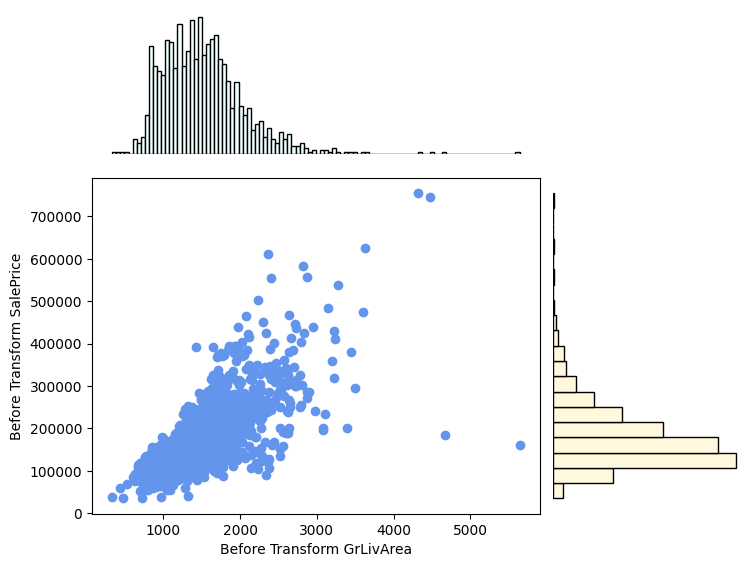

In [989]:
left, width = 1, 0.7
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.3]
rect_histy = [left_h, bottom, 0.3, height]
ax_scatter = plt.axes(rect_scatter)
rect_scatter=plt.scatter(df['GrLivArea'], df['SalePrice'],color='cornflowerblue')
plt.xlabel("Before Transform GrLivArea")
plt.ylabel("Before Transform SalePrice")
ax_histx = plt.axes(rect_histx)
plt.hist(df['GrLivArea'],bins=100,edgecolor='black',color='azure')
plt.axis('off')

ax_histy = plt.axes(rect_histy)
plt.hist(df['SalePrice'],orientation='horizontal',bins=20,edgecolor='black',color='cornsilk')
plt.axis('off')

plt.show()

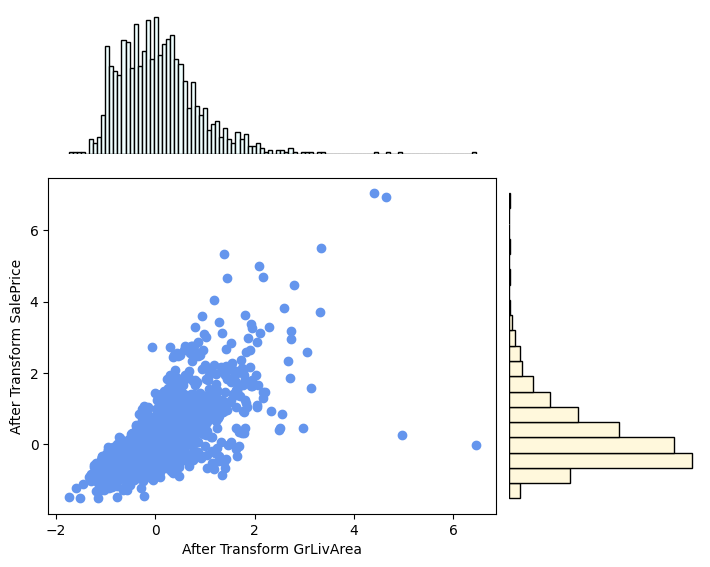

In [324]:
left, width = 1, 0.7
bottom, height = 0.1, 0.7
bottom_h = height + 0.15
left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.3]
rect_histy = [left_h, bottom, 0.3, height]
ax_scatter = plt.axes(rect_scatter)
rect_scatter=plt.scatter(pro_df['GrLivArea'], pro_df['SalePrice'],color='cornflowerblue')
plt.xlabel("After Transform GrLivArea")
plt.ylabel("After Transform SalePrice")
ax_histx = plt.axes(rect_histx)
plt.hist(pro_df['GrLivArea'],bins=100,edgecolor='black',color='azure')
plt.axis('off')

ax_histy = plt.axes(rect_histy)
plt.hist(pro_df['SalePrice'],orientation='horizontal',bins=20,edgecolor='black',color='cornsilk')
plt.axis('off')

plt.show()

## **3. Model Selection**
### **Summary:**


### **Section Highlights:**

In [1049]:
t_pro_df_tr,t_pro_df_tst=train_test_split(pro_df.sort_values(by=['YrSold','MoSold']),train_size=0.8,shuffle=False)

In [1048]:
pro_df_tr,pro_df_tst=train_test_split(pro_df,train_size=0.8,shuffle=True)

In [547]:
def cv_reg(df,split_type):
    #initialize score
    tr_df=df.copy()

    LRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    GBRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    XGBRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    RGscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    LSscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    LARSscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    DTRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    SVRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    RFRscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }
    LSLARSscore={'R2':[100,100,100,100,100],
            'RMSE':[100,100,100,100,100],
            'Adj_R2':[100,100,100,100,100],
            }

    if split_type=='time':
        tr_df=tr_df.sort_values(by=['YrSold','MoSold'])
        df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=False)
        df1,k2=train_test_split(df1,train_size=(0.75),shuffle=False)
        df1,k3=train_test_split(df1,train_size=(2/3),shuffle=False)
        k5,k4=train_test_split(df1,train_size=0.5,shuffle=False)
        a=[k1,k2,k3,k4,k5]
        
        for i in range(len(a)):
            if i==0:
                b=a[i]
            #continue merging different data set and train
            if i>0:
                b=pd.concat([b,a[i]],axis=0)
            k_tr,k_val=train_test_split(b,train_size=0.8,shuffle=False)
            #assign validation set
            train_x_=k_tr.drop('SalePrice',axis=1)
            train_y_=k_tr['SalePrice']
            val_x_=k_val.drop('SalePrice',axis=1)
            val_y_=k_val['SalePrice']

            LRModel=LR()
            LRModel.fit(train_x_, train_y_)
            pred_=LRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LRModel.n_features_in_-1)
            LRscore['R2'][i]=r2_
            LRscore['RMSE'][i]=rmse_
            LRscore['Adj_R2'][i]=adj_r2_
            result={'LinearReg':LRscore}

            GBRModel=GBR()
            GBRModel.fit(train_x_, train_y_)
            pred_=GBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-GBRModel.n_features_in_-1)            
            GBRscore['R2'][i]=r2_
            GBRscore['RMSE'][i]=rmse_
            GBRscore['Adj_R2'][i]=adj_r2_            
            result.update({'GradientBoostReg':GBRscore})

            XGBRModel=XGBR()
            XGBRModel.fit(train_x_, train_y_)
            pred_=XGBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-XGBRModel.n_features_in_-1)
            XGBRscore['R2'][i]=r2_
            XGBRscore['RMSE'][i]=rmse_
            XGBRscore['Adj_R2'][i]=adj_r2_
            result.update({'XGBReg':XGBRscore})

            RGModel=RG()
            RGModel.fit(train_x_, train_y_)
            pred_=RGModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RGModel.n_features_in_-1)
            RGscore['R2'][i]=r2_
            RGscore['RMSE'][i]=rmse_
            RGscore['Adj_R2'][i]=adj_r2_
            result.update({'Ridge':RGscore})

            LSModel=Lasso
            LSModel.fit(train_x_, train_y_)
            pred_=LSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSModel.n_features_in_-1)
            LSscore['R2'][i]=r2_
            LSscore['RMSE'][i]=rmse_
            LSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lasso':LSscore})            

            LARSModel=Lars
            LARSModel.fit(train_x_, train_y_)
            pred_=LARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LARSModel.n_features_in_-1)
            LARSscore['R2'][i]=r2_
            LARSscore['RMSE'][i]=rmse_
            LARSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lars':LARSscore})

            DTRModel=DTR()
            DTRModel.fit(train_x_, train_y_)
            pred_=DTRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-DTRModel.n_features_in_-1)
            DTRscore['R2'][i]=r2_
            DTRscore['RMSE'][i]=rmse_
            DTRscore['Adj_R2'][i]=adj_r2_
            result.update({'DecisionTreeReg':DTRscore})

            SVRModel=SVR()
            SVRModel.fit(train_x_, train_y_)
            pred_=SVRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-SVRModel.n_features_in_-1)
            SVRscore['R2'][i]=r2_
            SVRscore['RMSE'][i]=rmse_
            SVRscore['Adj_R2'][i]=adj_r2_
            result.update({'SupportVectorReg':SVRscore})

            RFRModel=RFR()
            RFRModel.fit(train_x_, train_y_)
            pred_=RFRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RFRModel.n_features_in_-1)
            RFRscore['R2'][i]=r2_
            RFRscore['RMSE'][i]=rmse_
            RFRscore['Adj_R2'][i]=adj_r2_            
            result.update({'RandomForestReg':RFRscore})
            
            LSLARSModel=LassoLars
            LSLARSModel.fit(train_x_, train_y_)
            pred_=LSLARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSLARSModel.n_features_in_-1)
            LSLARSscore['R2'][i]=r2_
            LSLARSscore['RMSE'][i]=rmse_
            LSLARSscore['Adj_R2'][i]=adj_r2_            
            result.update({'LassoLars':LSLARSscore})

            print(result)

    if split_type=='random':
        df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
        df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
        df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
        k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
        a=[k1,k2,k3,k4,k5]
        
        for i in range(len(a)):
            b=a.copy()
            val_x_=b[i].drop('SalePrice',axis=1)
            val_y_=b[i]['SalePrice']
            del b[i]
            k_tr=pd.DataFrame()
            for j in range(len(b)):
                k_tr=pd.concat([k_tr,b[j]],axis=0)
            train_x_=k_tr.drop('SalePrice',axis=1)
            train_y_=k_tr['SalePrice']

            LRModel=LR()
            LRModel.fit(train_x_, train_y_)
            pred_=LRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LRModel.n_features_in_-1)
            LRscore['R2'][i]=r2_
            LRscore['RMSE'][i]=rmse_
            LRscore['Adj_R2'][i]=adj_r2_
            result={'LinearReg':LRscore}

            GBRModel=GBR()
            GBRModel.fit(train_x_, train_y_)
            pred_=GBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-GBRModel.n_features_in_-1)            
            GBRscore['R2'][i]=r2_
            GBRscore['RMSE'][i]=rmse_
            GBRscore['Adj_R2'][i]=adj_r2_            
            result.update({'GradientBoostReg':GBRscore})

            XGBRModel=XGBR()
            XGBRModel.fit(train_x_, train_y_)
            pred_=XGBRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-XGBRModel.n_features_in_-1)
            XGBRscore['R2'][i]=r2_
            XGBRscore['RMSE'][i]=rmse_
            XGBRscore['Adj_R2'][i]=adj_r2_
            result.update({'XGBReg':XGBRscore})

            RGModel=RG()
            RGModel.fit(train_x_, train_y_)
            pred_=RGModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RGModel.n_features_in_-1)
            RGscore['R2'][i]=r2_
            RGscore['RMSE'][i]=rmse_
            RGscore['Adj_R2'][i]=adj_r2_
            result.update({'Ridge':RGscore})

            LSModel=Lasso
            LSModel.fit(train_x_, train_y_)
            pred_=LSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSModel.n_features_in_-1)
            LSscore['R2'][i]=r2_
            LSscore['RMSE'][i]=rmse_
            LSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lasso':LSscore})            

            LARSModel=Lars
            LARSModel.fit(train_x_, train_y_)
            pred_=LARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LARSModel.n_features_in_-1)
            LARSscore['R2'][i]=r2_
            LARSscore['RMSE'][i]=rmse_
            LARSscore['Adj_R2'][i]=adj_r2_
            result.update({'Lars':LARSscore})

            DTRModel=DTR()
            DTRModel.fit(train_x_, train_y_)
            pred_=DTRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-DTRModel.n_features_in_-1)
            DTRscore['R2'][i]=r2_
            DTRscore['RMSE'][i]=rmse_
            DTRscore['Adj_R2'][i]=adj_r2_
            result.update({'DecisionTreeReg':DTRscore})

            SVRModel=SVR()
            SVRModel.fit(train_x_, train_y_)
            pred_=SVRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-SVRModel.n_features_in_-1)
            SVRscore['R2'][i]=r2_
            SVRscore['RMSE'][i]=rmse_
            SVRscore['Adj_R2'][i]=adj_r2_
            result.update({'SupportVectorReg':SVRscore})

            RFRModel=RFR()
            RFRModel.fit(train_x_, train_y_)
            pred_=RFRModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-RFRModel.n_features_in_-1)
            RFRscore['R2'][i]=r2_
            RFRscore['RMSE'][i]=rmse_
            RFRscore['Adj_R2'][i]=adj_r2_            
            result.update({'RandomForestReg':RFRscore})
   
            LSLARSModel=LassoLars
            LSLARSModel.fit(train_x_, train_y_)
            pred_=LSLARSModel.predict(val_x_)
            rmse_=root_mean_squared_error(val_y_,pred_)
            r2_=r2_score(val_y_,pred_)
            adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-LSLARSModel.n_features_in_-1)
            LSLARSscore['R2'][i]=r2_
            LSLARSscore['RMSE'][i]=rmse_
            LSLARSscore['Adj_R2'][i]=adj_r2_            
            result.update({'LassoLars':LSLARSscore})

            print(result)

    return pd.DataFrame(result)

In [328]:
def split_result(df):
    result1=pd.DataFrame()
    score_dict={}
    for c in df.columns:
        for i in df.index:
            model=[]
            score_list=[]
            for cv in range(0,len(df[df.columns[0]][0])):
                score_list.append(df[c][i][round(cv,4)])
                model.append(c)
            score_dict.update({'model':model,i:score_list})
            result2=pd.DataFrame(score_dict)
        #print(result2)
        #print(c)
        result1=pd.concat([result1,result2],axis=0,ignore_index=True)
    return result1

In [639]:
def avg_summary(df):
    result1=pd.DataFrame()
    score_dict={}
    for m in df['model'].unique():
        for i in df.columns.drop('model'):
            score_dict.update({'model':m,i:sum(df.loc[df['model']==m][i])/len(df.loc[df['model']==m])})
        result2=pd.DataFrame(score_dict,index=[m])
        result1=pd.concat([result1,result2],axis=0,ignore_index=True)
    return result1

In [1055]:
result=cv_reg(t_pro_df_tr,'time')

{'LinearReg': {'R2': [-18.14988244614287, 100, 100, 100, 100], 'RMSE': [400578.07832737186, 100, 100, 100, 100], 'Adj_R2': [5.078215706123018, 100, 100, 100, 100]}, 'GradientBoostReg': {'R2': [0.9220283790005072, 100, 100, 100, 100], 'RMSE': [25560.680050640414, 100, 100, 100, 100], 'Adj_R2': [1.0166050674350773, 100, 100, 100, 100]}, 'XGBReg': {'R2': [0.8867095950150394, 100, 100, 100, 100], 'RMSE': [30810.637707204427, 100, 100, 100, 100], 'Adj_R2': [1.0241266603208712, 100, 100, 100, 100]}, 'Ridge': {'R2': [0.8787339467824445, 100, 100, 100, 100], 'RMSE': [31876.72854893657, 100, 100, 100, 100], 'Adj_R2': [1.025825178000035, 100, 100, 100, 100]}, 'Lasso': {'R2': [-0.028150225900584136, 100, 100, 100, 100], 'RMSE': [92818.04361271477, 100, 100, 100, 100], 'Adj_R2': [1.2189579184788282, 100, 100, 100, 100]}, 'Lars': {'R2': [-0.030634334546177255, 100, 100, 100, 100], 'RMSE': [92930.1045727626, 100, 100, 100, 100], 'Adj_R2': [1.2194869416163154, 100, 100, 100, 100]}, 'DecisionTreeReg':

In [993]:
pd.options.display.float_format = '{:.4f}'.format

In [1056]:
screening=split_result(result)

Summary screening result shows that XGBReg has the highest average R2 and lowest average RMSE

In [1057]:
print(avg_summary(screening).sort_values(by='R2',ascending=False))

              model                   R2              RMSE              Adj_R2
8   RandomForestReg               0.8030        33126.3933              1.3879
1  GradientBoostReg               0.7937        32514.4062              1.3618
2            XGBReg               0.6908        39676.2347              1.5055
3             Ridge               0.6449        40238.6840              1.5895
6   DecisionTreeReg               0.6096        48811.3872              1.7277
9         LassoLars               0.5841        45900.8580              1.8579
4             Lasso               0.4415        55228.9473              1.7249
5              Lars              -0.0094        81918.5844              3.4894
7  SupportVectorReg              -0.0507        83557.0602              3.5587
0         LinearReg -27018590123653.4922 230552821364.3453 16539774194508.0742


In [1058]:
selected_model=screening[screening['model'].isin([
            'XGBReg',
            'RandomForestReg',
            'GradientBoostReg',
            'Ridge',
            'Lasso',
            #'DecisionTreeReg',
            #'LassoLars',
            #'Lars',
            #'SupportVectorReg',
            #'LinearReg',
            ])]

for i in screening.columns.drop('model'):
    fig = px.box(
        selected_model,
            x='model',
            y=i,title=i)
    fig.add_trace(go.Scatter(x=selected_model['model'],y=selected_model[i],mode='markers',name='5-fold Cross Validation'),)
    fig.show()

## **4. Baseline Model Creation**
### **Summary:**


### **Section Highlights:**


In [1059]:
def reg_result(model,val_x,val_y):
    pred_=model.predict(val_x)
    rmse_=root_mean_squared_error(val_y,pred_)
    r2_=r2_score(val_y,pred_)
    adj_r2_=1-(1-r2_)*(len(val_x)-1)/(len(val_x)-model.n_features_in_-1)

    print(f'RMSE:${round(rmse_):,} R2:%.4f Adj R2:%.4f'%(r2_,adj_r2_))

    fig = px.line(
        x=val_y,
        y=val_y,
        title='Predict vs Actual',
        )
    fig.add_trace(
        go.Scatter(x=val_y,y=pred_,mode='markers',name='Model Prediction')
    )
    fig.update_layout(
        xaxis_title="Actual House Price", 
        yaxis_title="Predicted House Price"
        )
    fig.update_layout()
    fig.show()


GradientBoostingRegressor

In [1060]:
t_x_tr=t_pro_df_tr.drop('SalePrice',axis=1)
t_y_tr=t_pro_df_tr['SalePrice']
t_x_tst=t_pro_df_tst.drop('SalePrice',axis=1)
t_y_tst=t_pro_df_tst['SalePrice']

In [1023]:
x_tr=pro_df_tr.drop('SalePrice',axis=1)
y_tr=pro_df_tr['SalePrice']
x_tst=pro_df_tst.drop('SalePrice',axis=1)
y_tst=pro_df_tst['SalePrice']

In [1025]:
def opt_gbr_model(hpdict,train_x,train_y):

    GBRmodel=GBR(
        alpha=hpdict['alpha'],
        ccp_alpha=hpdict['ccp_alpha'],
        criterion=hpdict['criterion'],
        #init=hpdict['init'],
        learning_rate=hpdict['learning_rate'],
        loss=hpdict['loss'],
        max_depth=hpdict['max_depth'],
        #max_features=hpdict['max_features'],
        #max_leaf_nodes=hpdict['max_leaf_nodes'],
        min_impurity_decrease=hpdict['min_impurity_decrease'],
        #min_samples_leaf=hpdict['min_samples_leaf'],
        #min_samples_split=hpdict['min_samples_split'],
        min_weight_fraction_leaf=hpdict['min_weight_fraction_leaf'],
        n_estimators=1000,
        #n_estimators=hpdict['n_estimators'],
        #n_iter_no_change=hpdict['n_iter_no_change'],
        #random_state=hpdict['random_state'],
        subsample=hpdict['subsample'],
        #tol=hpdict['tol'],
        #validation_fraction=hpdict['validation_fraction'],
        verbose=0,
        #warm_start=hpdict['warm_start']
        )

    GBRmodel.fit(train_x,train_y,)

    return GBRmodel

In [1026]:
hp_example={
'alpha': 0.01,
'ccp_alpha': 0.01,
'criterion': 'friedman_mse',
#'init': None,
'learning_rate': 0.05,
'loss': 'squared_error',
'max_depth': 5,
#'max_features': None,
#'max_leaf_nodes': None,
'min_impurity_decrease': 5,
#'min_samples_leaf': 1,
#'min_samples_split': 0.2,
'min_weight_fraction_leaf': 0.1,
#'n_estimators': 1000,
#'n_iter_no_change': None,
#'random_state': None,
'subsample': 0.5,
#'tol': 0.0001,
#'validation_fraction': 0.1,
'verbose': 0,
#'warm_start': False,
}

In [1061]:
Model=opt_gbr_model(hp_example,t_x_tr,t_y_tr)

In [1062]:
#reg_result(Model,x_tr,y_tr)
reg_result(Model,t_x_tst,t_y_tst)

RMSE:$24,991 R2:0.8919 Adj R2:-0.0843


In [1029]:
def objective_random_cv_gbr(trial):
   
    tr_df=pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['squared_error','absolute_error','huber','quantile']
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',0,1),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',0,100),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',0,1),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth', 1,20),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2,100),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0.01,100),
    #'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,100),
    #'min_samples_split': trial.suggest_uniform('min_samples_split', 0.01,1),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.,0.5),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample', 0.01,0.5),
    #'tol': trial.suggest_uniform('tol', 0.0,100),
    #'validation_fraction': trial.suggest_uniform('validation_fraction', 0,1),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    #best_score=sum(cv_score)/len(cv_score)
    best_score=max(cv_score)

    return best_score

In [1063]:
def objective_time_cv_gbr(trial):
   
    tr_df=t_pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['squared_error','absolute_error','huber','quantile']
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',0,1),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',0,100),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',0,1),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth', 1,20),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2,100),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease', 0.01,100),
    #'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,100),
    #'min_samples_split': trial.suggest_uniform('min_samples_split', 0.01,1),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.,0.5),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample', 0.01,0.5),
    #'tol': trial.suggest_uniform('tol', 0.0,100),
    #'validation_fraction': trial.suggest_uniform('validation_fraction', 0,1),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    #best_score=sum(cv_score)/len(cv_score)
    best_score=max(cv_score)

    return best_score

In [1064]:
study1 = optuna.create_study(direction="minimize")
study1.optimize(objective_time_cv_gbr, n_trials=100)
hp_optuna = study1.best_params
hp01=study1.best_params

[I 2024-07-03 21:36:01,627] A new study created in memory with name: no-name-85d223fb-9745-4293-92d8-5c8f1d3fb772
[I 2024-07-03 21:36:06,675] Trial 0 finished with value: 1.7146513384656357e+50 and parameters: {'alpha': 0.09100884972279766, 'ccp_alpha': 30.558144751157045, 'criterion': 'squared_error', 'learning_rate': 0.8232732336202458, 'loss': 'huber', 'max_depth': 10, 'min_impurity_decrease': 75.86721632986722, 'min_weight_fraction_leaf': 0.037303708067199404, 'subsample': 0.0201000217919945}. Best is trial 0 with value: 1.7146513384656357e+50.
[I 2024-07-03 21:36:12,195] Trial 1 finished with value: 54394.0 and parameters: {'alpha': 0.35360851904230284, 'ccp_alpha': 23.601041489498275, 'criterion': 'squared_error', 'learning_rate': 0.035690082147549984, 'loss': 'huber', 'max_depth': 11, 'min_impurity_decrease': 65.02882894626683, 'min_weight_fraction_leaf': 0.4142592694623133, 'subsample': 0.32292644201505544}. Best is trial 1 with value: 54394.0.
[I 2024-07-03 21:36:15,760] Trial

In [1065]:
hp01

{'alpha': 0.603523493379314,
 'ccp_alpha': 79.16945939427235,
 'criterion': 'squared_error',
 'learning_rate': 0.21051688136128727,
 'loss': 'squared_error',
 'max_depth': 4,
 'min_impurity_decrease': 71.4138593114865,
 'min_weight_fraction_leaf': 0.01521692272635547,
 'subsample': 0.4615230082467843}

In [1066]:
Model1=opt_gbr_model(hp01,t_x_tr,t_y_tr)
#reg_result(Model1,x_tr,y_tr)
reg_result(Model1,t_x_tst,t_y_tst)

RMSE:$25,059 R2:0.8914 Adj R2:-0.0902


In [1067]:
optuna.visualization.plot_param_importances(study1)

## **5. Feature Engineering and Model Tunning**
### **Summary:**


### **Section Highlights:**


In [838]:
def feat_importance(model):
    feat_df=pd.DataFrame(data={'Feature':model.feature_names_in_,'Importance':model.feature_importances_,})
    print('Total feature count is',len(feat_df['Feature']))
    
    fig = px.bar(feat_df.sort_values(by='Importance',ascending=True),text_auto=True, y='Feature', x='Importance',orientation='h',title="Feature Importance")
    fig.show()

    fig = px.histogram(feat_df, x="Importance",histnorm='percent',nbins=5*len(feat_df),marginal='box',title="Feature Importance Distribution")
    fig.show()

    fig = px.ecdf(feat_df, x="Importance",marginal="histogram",title="Cumulative Distribution of Feature Importance")
    fig.show()

    return feat_df

In [1068]:
model_feat1=feat_importance(Model1)

Total feature count is 262


In [1069]:
def select_feat(model_feat,criteria):
    fe_to_select=model_feat[model_feat['Importance']>criteria]
    fe_to_remove=model_feat[model_feat['Importance']<=criteria]

    print(f'Total {len(fe_to_remove)} features to be removed based on criteria lower than',criteria)
    display(fe_to_remove.sort_values(by='Importance',ascending=False))

    print(f'Total {len(fe_to_select)} features to be retained based on criteria higher than',criteria)
    display(fe_to_select.sort_values(by='Importance',ascending=False))

    return fe_to_select,fe_to_remove

In [1070]:
selected_feat,remove_feat=select_feat(model_feat1,0.0001)

Total 143 features to be removed based on criteria lower than 0.0001


,Feature,Importance
82,HouseStyle_SLvl,0.0001
115,Exterior2nd_BrkFace,0.0001
17,LandContour_Lvl,0.0001
126,Exterior2nd_Wd Sdng,0.0001
26,LandSlope_Mod,0.0001
...,...,...
87,RoofStyle_Mansard,0.0000
85,RoofStyle_Gambrel,0.0000
83,RoofStyle_Flat,0.0000
79,HouseStyle_2.5Unf,0.0000


Total 119 features to be retained based on criteria higher than 0.0001


,Feature,Importance
207,OverallQual,0.3751
218,GrLivArea,0.1148
214,TotalBsmtSF,0.0679
215,1stFlrSF,0.0362
206,LotArea,0.0356
...,...,...
75,HouseStyle_1.5Fin,0.0001
33,Neighborhood_CollgCr,0.0001
251,GarageCond,0.0001
199,MSSubClass_80,0.0001


In [ ]:
def update_feat(fe_to_remove,pro_df_tr_,tr_x_,tst_x_):
    fe_pro_df_tr_=pro_df_tr_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    fe_tr_x_=tr_x_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    fe_tst_x_=tst_x_.drop(fe_to_remove['Feature'].tolist(),axis=1)
    return fe_pro_df_tr_,fe_tr_x_,fe_tst_x_

In [1071]:
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,t_pro_df_tr,t_x_tr,t_x_tst)

In [1074]:
Model2=opt_gbr_model(hp01,fe_x_tr,t_y_tr)
#reg_result(Model2,fe_x_tr,y_tr)
reg_result(Model2,fe_x_tst,t_y_tst)

RMSE:$28,710 R2:0.8574 Adj R2:0.7587


In [867]:
def objective_random_cv_gbr_fe(trial):
   
    tr_df=pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['squared_error','absolute_error','huber','quantile']
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',max(0,hp_optuna['alpha']-0.1),min(hp_optuna['alpha']+0.1,1)),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',max(0,hp_optuna['ccp_alpha']-10),min(hp_optuna['ccp_alpha']+10,100)),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',max(0,hp_optuna['learning_rate']-0.1),min(hp_optuna['learning_rate']+0.1,1)),
    'loss': trial.suggest_categorical('loss',gbr_loss),
    'max_depth': trial.suggest_int('max_depth',max(1,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2,100),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease',max(0,hp_optuna['min_impurity_decrease']-10),min(hp_optuna['min_impurity_decrease']+10,100)),
    #'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,100),
    #'min_samples_split': trial.suggest_uniform('min_samples_split', 0.01,1),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf',max(0,hp_optuna['min_weight_fraction_leaf']-0.1),min(hp_optuna['min_weight_fraction_leaf']+0.1,1)),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample',max(0,hp_optuna['subsample']-0.1),min(hp_optuna['subsample']+0.1,0.5)),
    #'tol': trial.suggest_uniform('tol', 0.0,100),
    #'validation_fraction': trial.suggest_uniform('validation_fraction', 0,1),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    #best_score=sum(cv_score)/len(cv_score)
    best_score=max(cv_score)

    return best_score

In [894]:
study2 = optuna.create_study(direction="minimize")
study2.optimize(objective_random_cv_gbr_fe, n_trials=100)
hp_optuna = study2.best_params
hp02=study2.best_params

[I 2024-07-03 17:03:31,320] A new study created in memory with name: no-name-7c935f74-caa8-49fc-b59c-7a85081929de
[I 2024-07-03 17:03:36,051] Trial 0 finished with value: 132375.0 and parameters: {'alpha': 0.90041880657904, 'ccp_alpha': 83.24538391944486, 'criterion': 'squared_error', 'learning_rate': 0.01849007351201195, 'loss': 'quantile', 'max_depth': 6, 'min_impurity_decrease': 32.49386289295643, 'min_weight_fraction_leaf': 0.08526919125563923, 'subsample': 0.4075452333467525}. Best is trial 0 with value: 132375.0.
[I 2024-07-03 17:03:51,059] Trial 1 finished with value: 32651.0 and parameters: {'alpha': 0.9521321270112222, 'ccp_alpha': 84.58077914297183, 'criterion': 'friedman_mse', 'learning_rate': 0.06096124840203759, 'loss': 'huber', 'max_depth': 5, 'min_impurity_decrease': 42.248997749762424, 'min_weight_fraction_leaf': 0.08832702359422998, 'subsample': 0.4172559180459092}. Best is trial 1 with value: 32651.0.
[I 2024-07-03 17:03:55,716] Trial 2 finished with value: 91787.0 an

In [895]:
hp02

{'alpha': 0.9467549706041141,
 'ccp_alpha': 94.45187122447162,
 'criterion': 'squared_error',
 'learning_rate': 0.015506170506825102,
 'loss': 'huber',
 'max_depth': 6,
 'min_impurity_decrease': 40.13818652341894,
 'min_weight_fraction_leaf': 0.04307831028270312,
 'subsample': 0.3980401545461402}

In [920]:
Model3=opt_gbr_model(hp02,fe_x_tr,y_tr)
reg_result(Model3,fe_x_tr,y_tr)
reg_result(Model3,fe_x_tst,y_tst)

RMSE:$20,266 R2:0.9360 Adj R2:0.9223


RMSE:$30,685 R2:0.8384 Adj R2:0.4467


In [897]:
optuna.visualization.plot_param_importances(study2)

In [899]:
model_feat2=feat_importance(Model3)

Total feature count is 105


In [968]:
selected_feat,remove_feat=select_feat(model_feat2,0.001)

Total 58 features to be removed based on criteria lower than 0.001


,Feature,Importance
78,BedroomAbvGr,0.0009
52,PavedDrive_Y,0.0007
94,HeatingQC,0.0007
93,BsmtCond,0.0007
85,EnclosedPorch,0.0006
33,Exterior1st_VinylSd,0.0006
5,LotShape_IR1,0.0006
53,SaleType_New,0.0005
45,GarageType_Attchd,0.0005
21,Neighborhood_OldTown,0.0005


Total 47 features to be retained based on criteria higher than 0.001


,Feature,Importance
64,OverallQual,0.3890
74,GrLivArea,0.1307
90,ExterQual,0.0773
71,TotalBsmtSF,0.0468
68,BsmtFinSF1,0.0392
82,GarageArea,0.0333
95,KitchenQual,0.0320
63,LotArea,0.0274
81,GarageCars,0.0274
72,1stFlrSF,0.0211


In [969]:
fe_pro_df_tr,fe_x_tr,fe_x_tst=update_feat(remove_feat,pro_df_tr,x_tr,x_tst)
Model3=opt_gbr_model(hp02,fe_x_tr,y_tr)
reg_result(Model3,fe_x_tr,y_tr)
reg_result(Model3,fe_x_tst,y_tst)

RMSE:$20,365 R2:0.9354 Adj R2:0.9222


RMSE:$30,646 R2:0.8388 Adj R2:0.4956


In [965]:
def objective_random_cv_gbr_fe2(trial):
   
    tr_df=pro_df_tr.copy()
    df1,k1=train_test_split(tr_df,train_size=0.8,shuffle=True)
    df1,k2=train_test_split(df1,train_size=(0.75),shuffle=True)
    df1,k3=train_test_split(df1,train_size=(2/3),shuffle=True)
    k5,k4=train_test_split(df1,train_size=0.5,shuffle=True)
    a=[k1,k2,k3,k4,k5]
    cv_score=[100,100,100,100,100]

    gbr_loss=['squared_error','absolute_error','huber','quantile']
    gbr_criterion=['friedman_mse', 'squared_error']
    gbr_optuna_hpdic={
    'alpha': trial.suggest_uniform('alpha',max(0,hp_optuna['alpha']-0.1),min(hp_optuna['alpha']+0.1,1)),
    'ccp_alpha': trial.suggest_uniform('ccp_alpha',max(0,hp_optuna['ccp_alpha']-10),min(hp_optuna['ccp_alpha']+10,100)),
    'criterion': trial.suggest_categorical('criterion',gbr_criterion),
    #'init': None,
    'learning_rate': trial.suggest_uniform('learning_rate',max(0,hp_optuna['learning_rate']-0.1),min(hp_optuna['learning_rate']+0.1,1)),
    'loss': 'huber',
    'max_depth': trial.suggest_int('max_depth',max(1,hp_optuna["max_depth"]-5),min(hp_optuna["max_depth"]+5,24)),
    #'max_features': trial.suggest_int('max_features', 1,len(tr_df.drop('SalePrice',axis=1).columns)),
    #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2,100),
    'min_impurity_decrease': trial.suggest_uniform('min_impurity_decrease',max(0,hp_optuna['min_impurity_decrease']-10),min(hp_optuna['min_impurity_decrease']+10,100)),
    #'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,100),
    #'min_samples_split': trial.suggest_uniform('min_samples_split', 0.01,1),
    'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf',max(0,hp_optuna['min_weight_fraction_leaf']-0.1),min(hp_optuna['min_weight_fraction_leaf']+0.1,1)),
    #'n_estimators': trial.suggest_int('n_estimators', 1000,5000),
    #'n_iter_no_change': trial.suggest_int('n_iter_no_change', 1,100),
    #'random_state': trial.suggest_int('random_state', 0,2**32-1),
    'subsample': trial.suggest_uniform('subsample',max(0,hp_optuna['subsample']-0.1),min(hp_optuna['subsample']+0.1,0.5)),
    #'tol': trial.suggest_uniform('tol', 0.0,100),
    #'validation_fraction': trial.suggest_uniform('validation_fraction', 0,1),
    #'verbose': 0,
    #'warm_start': False,
    }

    for i in range(len(a)):
        b=a.copy()
        val_x_=b[i].drop('SalePrice',axis=1)
        val_y_=b[i]['SalePrice']
        del b[i]
        k_tr=pd.DataFrame()
        for j in range(len(b)):
            k_tr=pd.concat([k_tr,b[j]],axis=0)

        train_x_=k_tr.drop('SalePrice',axis=1)
        train_y_=k_tr['SalePrice']

        model=opt_gbr_model(gbr_optuna_hpdic,train_x_,train_y_)
        pred_=model.predict(val_x_)
        rmse_=round(root_mean_squared_error(val_y_,pred_),0)
        r2_=r2_score(val_y_,pred_)
        adj_r2_=1-(1-r2_)*(len(val_x_)-1)/(len(val_x_)-model.n_features_in_-1)

        cv_score[i]=rmse_

    #best_score=sum(cv_score)/len(cv_score)
    best_score=max(cv_score)

    return best_score

In [ ]:
study3 = optuna.create_study(direction="minimize")
study3.optimize(objective_random_cv_gbr_fe2, n_trials=100)
hp_optuna = study3.best_params
hp03=study3.best_params

In [952]:
hp03

{'alpha': 0.9250023832966806,
 'ccp_alpha': 94.74013144570027,
 'criterion': 'friedman_mse',
 'learning_rate': 0.019937629976988742,
 'max_depth': 4,
 'min_impurity_decrease': 42.79336223273909,
 'min_weight_fraction_leaf': 0.03192247725738407,
 'subsample': 0.3586731614143021}

In [953]:
hp03.update({'loss': 'huber',})

In [970]:
Model4=opt_gbr_model(hp03,fe_x_tr,y_tr)
reg_result(Model4,fe_x_tr,y_tr)
reg_result(Model4,fe_x_tst,y_tst)

RMSE:$19,480 R2:0.9409 Adj R2:0.9288


RMSE:$30,936 R2:0.8357 Adj R2:0.4860


In [955]:
optuna.visualization.plot_param_importances(study3)